# Minimise Cost with Tariff
This notebook minimises the cost for the house by shifting the load throughout the day
The load is simulated by taking the average duration is runs annually, and the rated power

There are 4 different tariffs that can be applied.


## Select a house
| HouseID   |   Load        |
|---------  |   ------      |
|64613      |   hot_water   |
|70210      |   pool        |
|70243      |   hot_water   |
|70277      |   hot_water   |
|91912      |   pool        |
|91910      |   hot_water   |

In [1]:
from os import path
from os import getcwd, listdir
path_to_data = path.join('..', 'data', 'houses')
houses = listdir(path_to_data)
for h in houses: print(path.split('_')[0])

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from thesisInitial.cleaning_data import extract_data_from_house, \
    extract_rated_power, extract_average_time_on, prepare_features
import seaborn as sns
import thesisInitial.tariff as tf
import time
from datetime import date, datetime

Y = 2000 # dummy leap year to allow input X-02-29 (leap day)
seasons = [('summer', (date(Y,  1,  1),  date(Y,  2, 29))),
           ('autumn', (date(Y,  3, 1),  date(Y,  5, 31))),
           ('winter', (date(Y,  6, 1),  date(Y,  8, 31))),
           ('spring', (date(Y,  9, 1),  date(Y, 11, 30))),
           ('summer', (date(Y, 12, 1),  date(Y, 12, 31)))]

def get_season(now):
    if isinstance(now, datetime):
        now = now.date()
    now = now.replace(year=Y)
    return next(season for season, (start, end) in seasons
                if start <= now <= end)

sns.set()
house_id = 64613

### Importing Data and cleaning up

In [3]:
data = extract_data_from_house(house_id, load_on=True)
rated_power = extract_rated_power(data.load)
average_duration = extract_average_time_on(data.load)
data.head()

,Location,load,PV,AC,total_use,grid_import,grid_export
2019-01-01 00:00:00,Sydney,0.0194,-0.0733,70.0850,70.0311,70.1044,0.0
2019-01-01 00:05:00,Sydney,0.0197,-0.0736,69.2019,69.1480,69.2216,0.0
2019-01-01 00:10:00,Sydney,0.0192,-0.0728,66.6908,66.6372,66.7100,0.0
2019-01-01 00:15:00,Sydney,0.0194,-0.0733,68.1369,68.0830,68.1563,0.0
2019-01-01 00:20:00,Sydney,0.0225,-0.0742,81.0847,81.0330,81.1072,0.0


### Setting Up the seasonal Estimates
Here I separated the data into seasons and extract the median load profile for each season

C:\Users\camer\PycharmProjects\Thesis\thesisInitial\cleaning_data.py:139: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  summer = median_data['2019-12'].append(median_data['2019-01':'2019-02'])


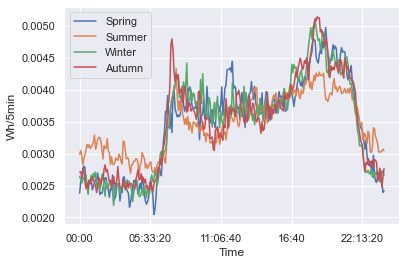

In [4]:
from thesisInitial.cleaning_data import extract_season_median_load_profile

normalised_median = extract_season_median_load_profile(data)

normalised_median.spring.plot(label='Spring')
normalised_median.summer.plot(label='Summer')
normalised_median.winter.plot(label='Winter')
normalised_median.autumn.plot(label='Autumn')
plt.ylabel('Wh/5min')
plt.legend()
plt.show()

### Training dataset

In [5]:
from thesisInitial.cleaning_data import prepare_features
feature_set = prepare_features(data)

features = [
        'Maximum temperature (Degree C)',
        'Daily global solar exposure (MJ/m*m)',
        'previous_day',
        'second_previous_day',
        'previous_week',
        'month',
        'weekend_weekday',
        'dayofweek',
        'daily_max'
            ]
# Drop any NA in the set as it breaks the regression
d = feature_set.dropna()

# Collect the features that are linearly dependent
X = d.loc[:,features[:]].to_numpy()

from sklearn.preprocessing import PolynomialFeatures
# I'm considering only temperature to be 2 degree polynomially fitted
x_temp = d.loc[:,features[0:1]].to_numpy()
x_temp = x_temp.reshape(-1,1)
poly = PolynomialFeatures(degree=2)
poly_variables = poly.fit_transform(x_temp)

# This is the target
y = d.loc[:,'total_use_wo_load'].to_numpy()
y = y.reshape(-1,1)

# Combine the Polynomial Feature and Linear Feature
x = np.concatenate((X, poly_variables), axis=1)

x_train = x[::2]
x_test  = x[1::2]
y_train = y[::2]
y_test  = y[1::2]

# x = X
# Create and train the linear regression model
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(x, y)

features = pd.DataFrame(data=x, index=d.index)
# f = features.loc['2019-02-19'].to_numpy()
print(feature_set.loc['2019-02-19'])

load                                               1.802401
PV                                                19.807516
AC                                                -0.954179
total_use                                         20.655739
grid_import                                       11.844342
grid_export                                        10.99612
total_use_wo_load                                 18.853337
Maximum temperature (Degree C)                         27.3
Daily global solar exposure (MJ/m*m)                   23.0
daily_max                                          508.6762
month                                                     2
previous_day                                      23.002074
second_previous_day                               14.275335
previous_week                                     24.116206
weekend_weekday                                           1
dayofweek                                                 1
dates                                   

### Tariff Choices
There are 4 Tariff Categories Currently
<li> flat
<li> Time of Use (TOU)
<li> Flat with controlled Load
<li> TOU with controlled load

In [6]:
tariff_type = 'TOU'
tariffs = tf.read_tariffs()

tariff = None
for t in tariffs:
    if t.tariff_type == tariff_type:
        tariff = t

print("Tariff Name: " + tariff.tariff_name)


Tariff Name: OriginGo


In [7]:
data['import_cost'] = tariff.get_cost(data.loc['2019'][['grid_import', 'load']] / 1000)
data['export_revenue'] = (data.loc['2019'].grid_export / 1000) * tariff.get_fit()
print('Import Cost' + " ${:.2f}".format(data.import_cost.sum() / 100))
print("Export Revenue" " ${:.2f}".format(data.export_revenue.sum() / 100))
print("Net Cost" + " ${:.2f}".format(data.import_cost.sum() / 100 - data.export_revenue.sum() / 100))

Import Cost $1306.76
Export Revenue $249.07
Net Cost $1057.69


#### Preload Possible Load Times Using Average Duration and Rated Power

In [8]:
# Date Range to Minimise Cost
date_range = '2019-02'

from thesisInitial.possible_load import ExtractLoad
possible_load = ExtractLoad(data.loc[date_range].load)

### Minimising Cost Loop
Loops over all the possible load start times and returns the load and cost of the minimum load start time

In [9]:
days_in_set = data[date_range].index.date
days_in_set = np.unique(days_in_set)
min_cost_load = pd.Series(dtype='float64')
start = time.time()
for day in days_in_set:
    date = str(day)
    print(date)

     # Season is extracted and normalised season median profile is scaled
    season = get_season(day)
    total_use_sum = model.predict([features.loc[date].to_numpy()])[0]
    if season == 'summer': total_use_without_load = normalised_median.summer * total_use_sum
    elif season == 'winter': total_use_without_load = normalised_median.winter * total_use_sum
    elif season == 'autumn': total_use_without_load = normalised_median.autumn * total_use_sum
    else: total_use_without_load = normalised_median.spring * total_use_sum
    # total_use_without_load = data[date].total_use - data[date].load
    # print(len(total_use_without_load))

    pv_day = data.PV[date]
    grid_import_cost = tariff.get_cost(data.loc[date][['grid_import', 'load']] / 1000).sum()
    grid_export_revenue = data.loc[date]['grid_export'] / 1000 * tariff.get_fit()
    # min_cost = grid_import_cost.sum() - grid_export_revenue.sum()
    min_cost = 10000
    max_time = 0
    max_load = data.loc[date].load
    index = pd.date_range(pd.to_datetime(date+" 00:00:00"), periods=288, freq='5T')
    tariff_series = tariff.get_tariff_from_time_index(index.hour).astype(float)
    total_use_without_load.index = index

    possible_load_day = possible_load.get_possible_load_date(date)
    for col in possible_load_day.columns:
        new_load = possible_load_day.loc[:,col]
        new_total_use = total_use_without_load + new_load
        new_grid_import = (new_total_use - pv_day).clip(lower=0)
        new_grid_export = ((new_total_use - pv_day) * -1).clip(lower=0)
        new_grid_import_cost = (new_grid_import / 1000) * tariff_series
        new_grid_export_revenue = (new_grid_export / 1000) * tariff.get_fit()
        new_cost_net = new_grid_import_cost.sum(axis=0) - new_grid_export_revenue.sum(axis=0)
        if new_cost_net < min_cost:
            min_cost = new_cost_net
            max_load = new_load
            max_time = col

    min_cost_load = pd.concat([min_cost_load, max_load], axis=0)
print(time.time() - start)
print('done')

<ipython-input-9-43bedcf4fa9b>:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  days_in_set = data[date_range].index.date
<ipython-input-9-43bedcf4fa9b>:25: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  max_load = data[date].load
<ipython-input-9-43bedcf4fa9b>:25: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  max_load = data[date].load
<ipython-input-9-43bedcf4fa9b>:25: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[strin

2019-02-01
2019-02-02
2019-02-03
2019-02-04
2019-02-05
2019-02-06
2019-02-07
2019-02-08
2019-02-09
2019-02-10
2019-02-11
2019-02-12
2019-02-13
2019-02-14
2019-02-15
2019-02-16
2019-02-17
2019-02-18
2019-02-19
2019-02-20
2019-02-21
2019-02-22
2019-02-23
2019-02-24
2019-02-25
2019-02-26
2019-02-27
2019-02-28
19.835267543792725
done


### Makes a new Dataframe with the minimised load instead of the real load

In [10]:
data_copy = data[date_range].copy(deep=True)
new_load = min_cost_load[~min_cost_load.index.duplicated(keep='last')]
new_load = new_load.rename('load')
new_total_use = (data_copy.total_use - data_copy.load + new_load).rename('total_use')
new_AC = (new_total_use - data_copy.PV).rename('AC')
new_grid_import = new_AC.clip(lower=0).rename('grid_import')
new_grid_export = (new_AC * -1).clip(lower=0).rename('grid_export')
new_data = pd.concat([new_load, data_copy.PV, new_AC, new_total_use, new_grid_import, new_grid_export], axis=1)

<ipython-input-10-e82b249d5d56>:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  data_copy = data[date_range].copy(deep=True)


<ipython-input-11-2956d98f93ba>:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  days_in_set = data[date_range].index.date
<ipython-input-11-2956d98f93ba>:7: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  data[date].total_use.plot(ax=ax[0], alpha=0.5)
<ipython-input-11-2956d98f93ba>:8: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  data[date].load.clip(lower=0).plot.area(ax=ax[0])
<ipython-input-11-2956d98f93ba>:9: FutureWarning: Indexing a DataFrame with a datetimelike index using a single

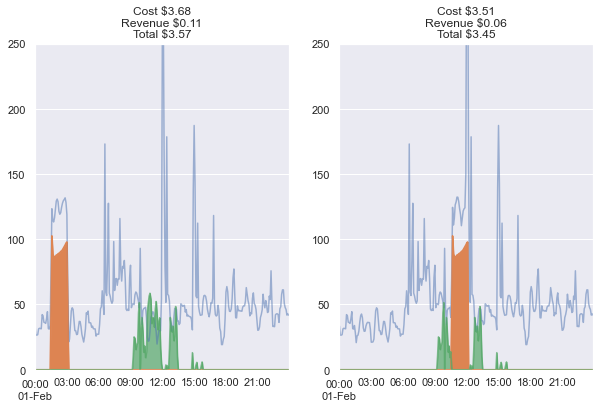

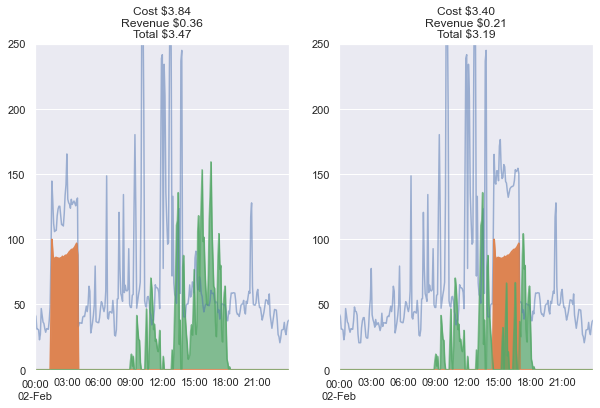

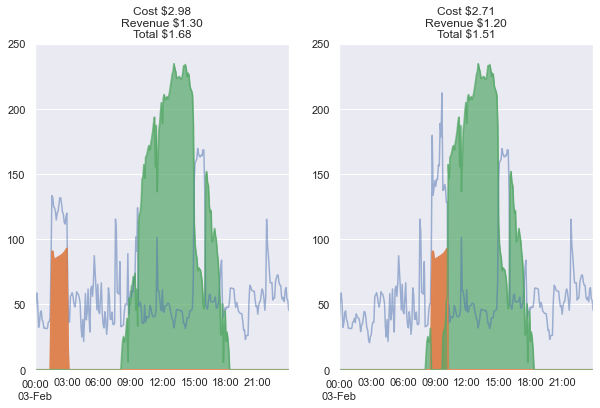

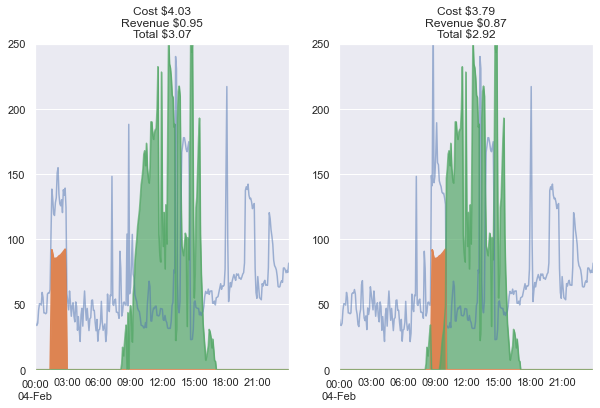

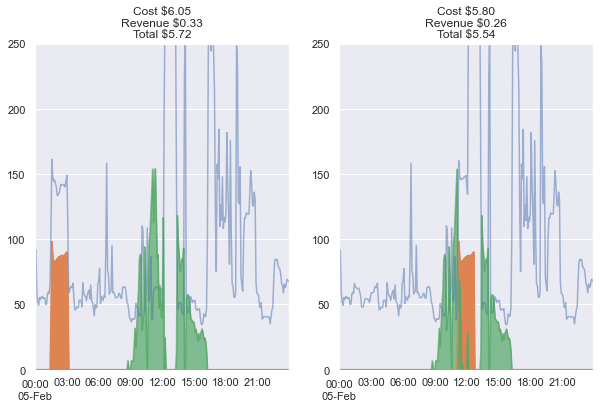

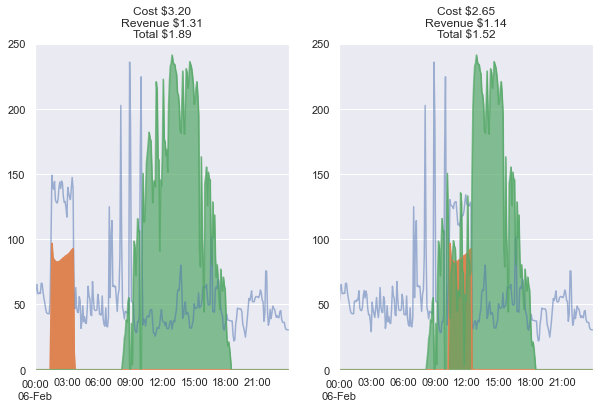

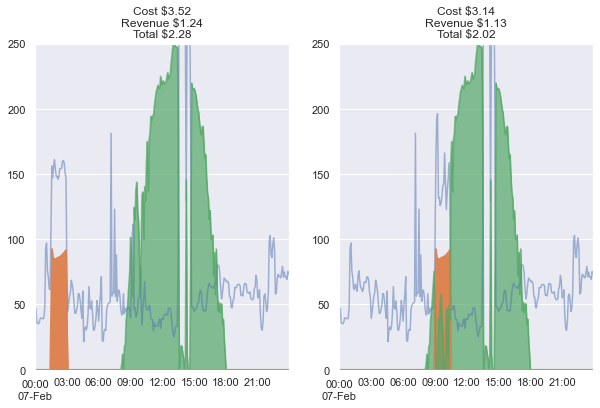

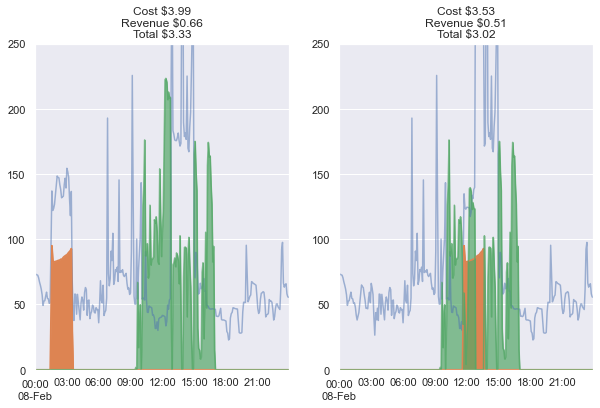

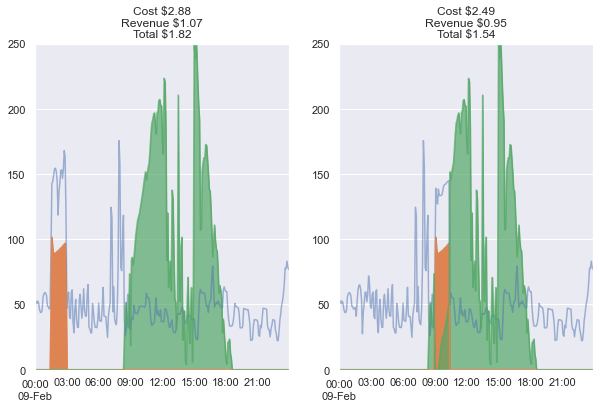

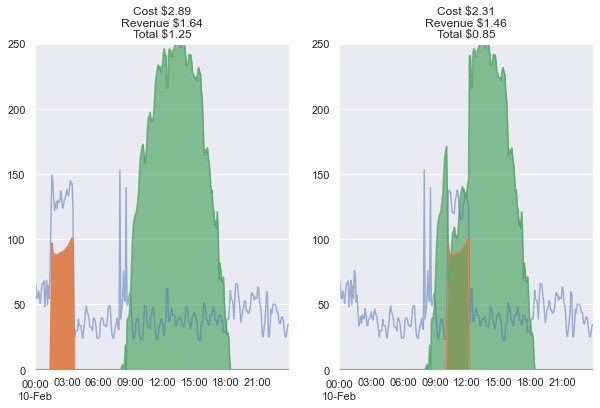

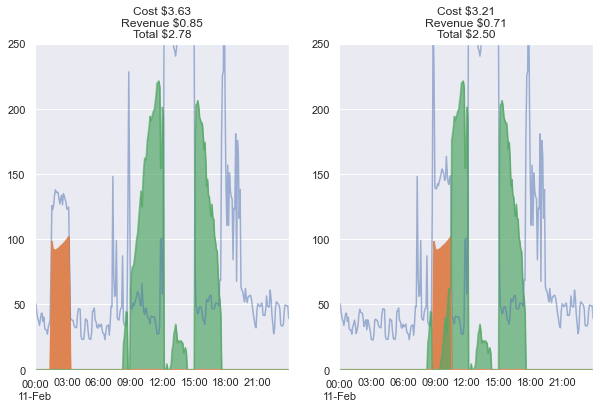

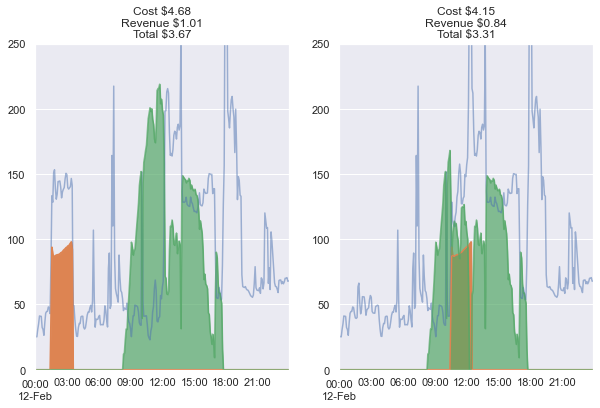

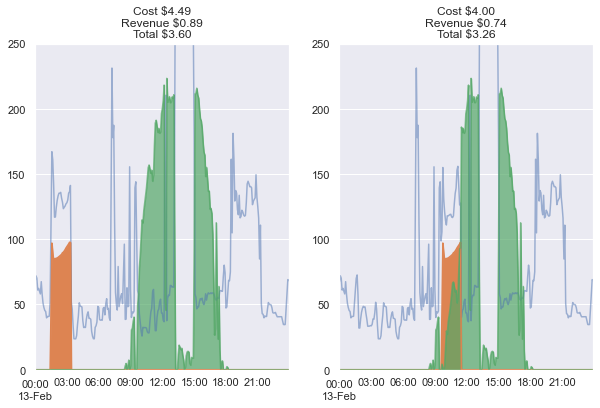

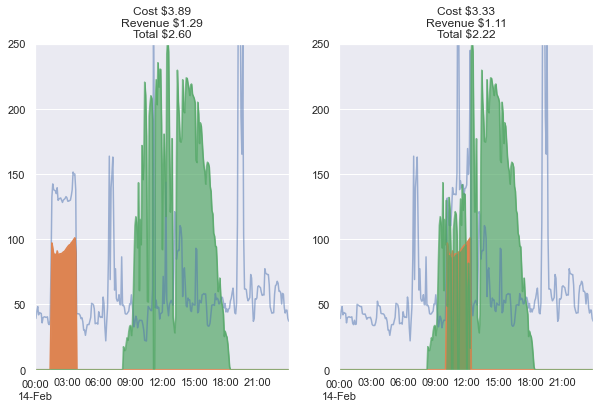

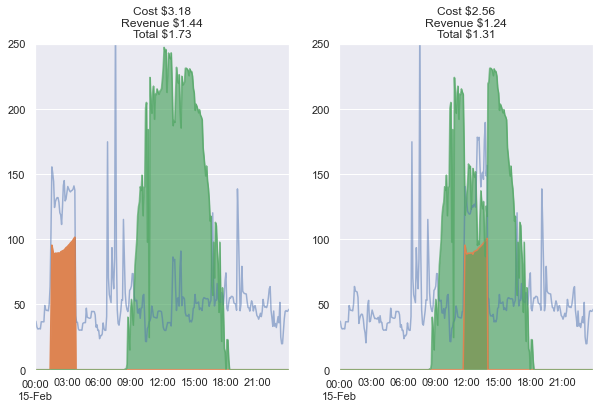

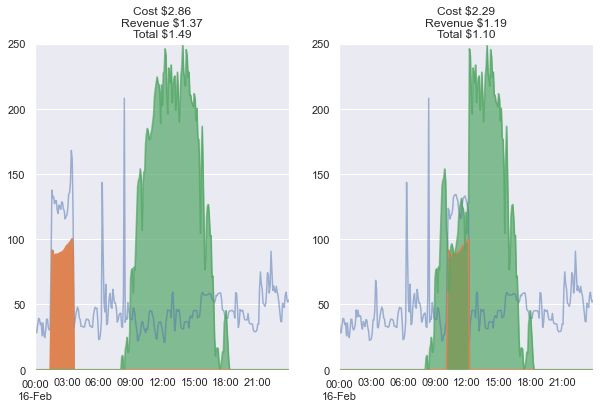

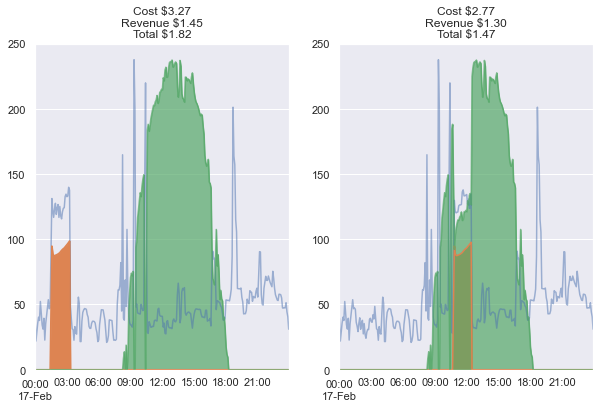

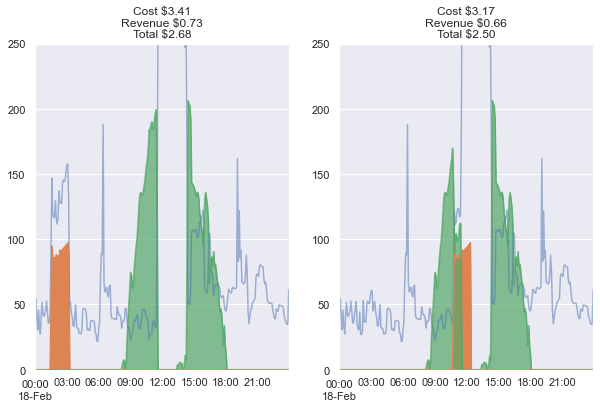

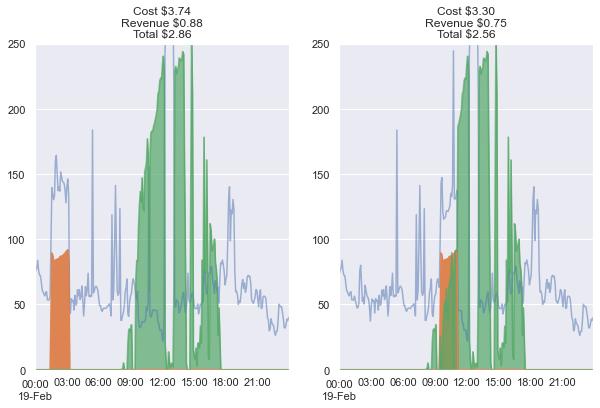

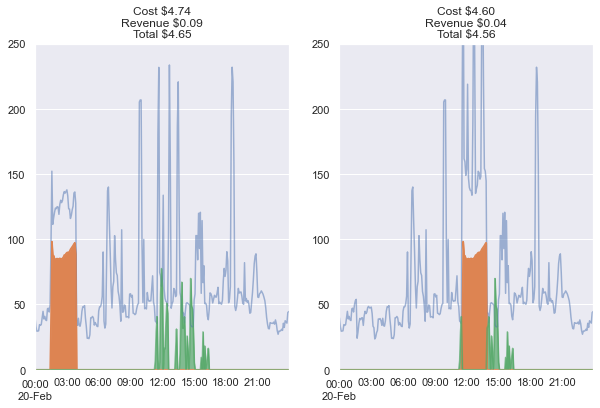

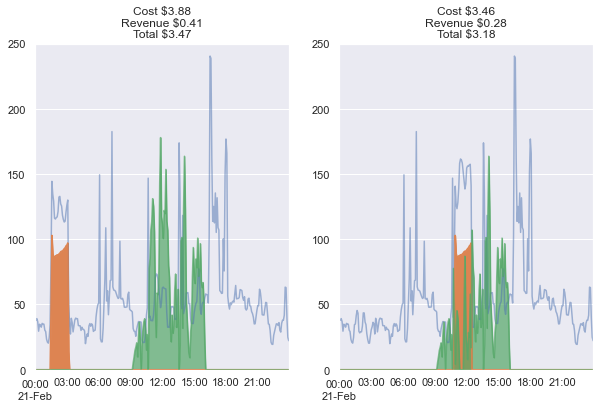

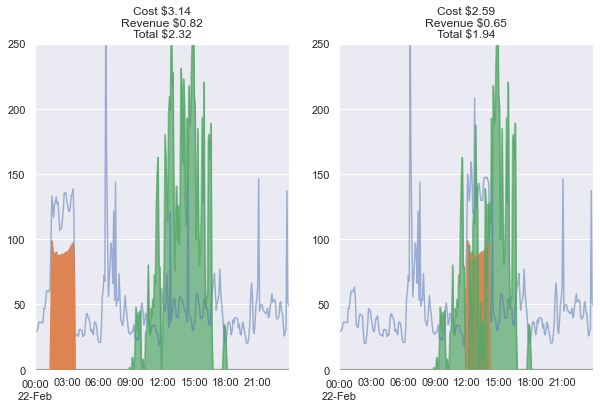

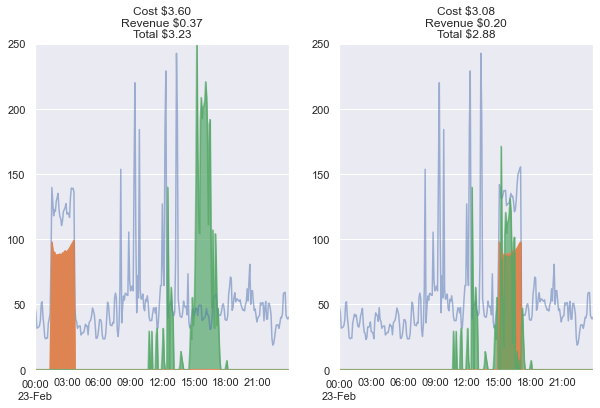

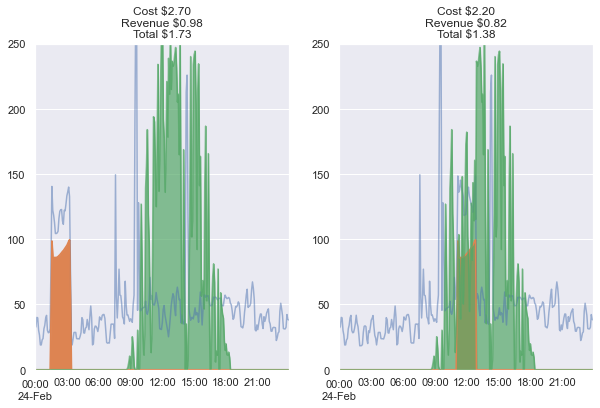

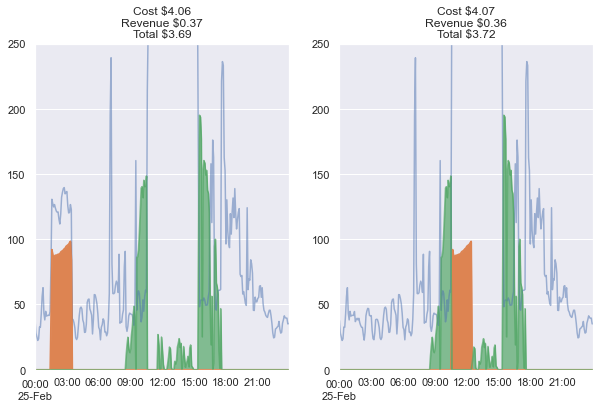

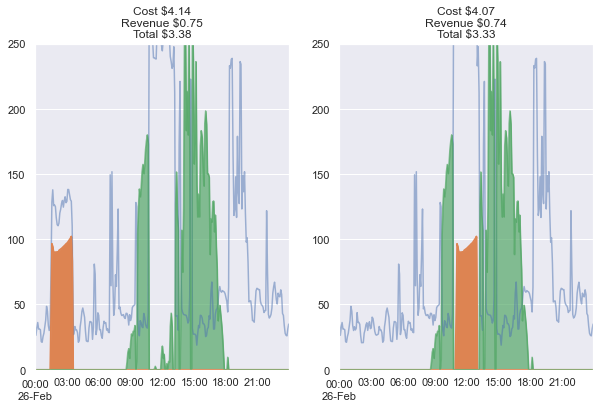

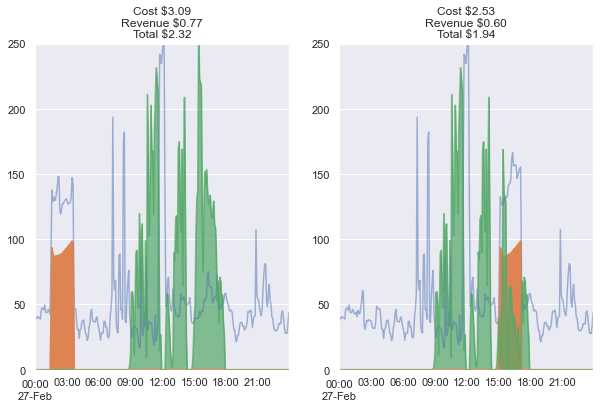

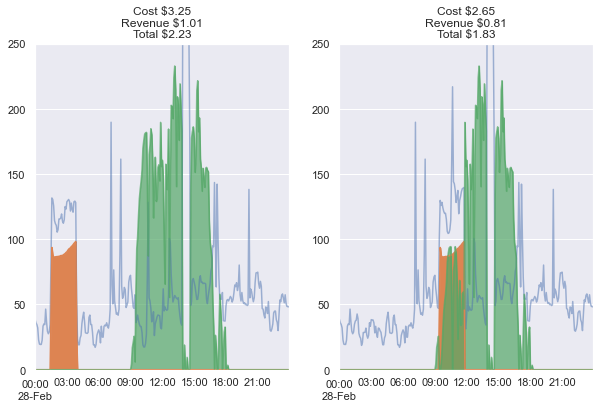

In [11]:
date = '2019-01-30'
days_in_set = data[date_range].index.date
days_in_set = np.unique(days_in_set)
for day in days_in_set:
    date = str(day)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,6))
    data[date].total_use.plot(ax=ax[0], alpha=0.5)
    data[date].load.clip(lower=0).plot.area(ax=ax[0])
    data[date].grid_export.plot.area(ax=ax[0], alpha=0.7)
    cost = tariff.get_cost(data[date][['grid_import', 'load']]/1000).sum() / 100
    revenue = ((data[date].grid_export / 1000) * tariff.get_fit()).sum() / 100
    ax[0].set_title('Cost $%.2f\nRevenue $%.2f\nTotal $%.2f' % (cost, revenue, cost-revenue))
    ax[0].set_ylim([0,250])
    new_data[date].total_use.plot(ax=ax[1], alpha=0.5)
    new_data[date].load.clip(lower=0).plot.area(ax=ax[1])
    new_data[date].grid_export.plot.area(ax=ax[1], alpha=0.7)
    cost = tariff.get_cost(new_data[date][['grid_import', 'load']]/1000).sum() / 100
    revenue = ((new_data[date].grid_export / 1000) * tariff.get_fit()).sum() / 100
    ax[1].set_title('Cost $%.2f\nRevenue $%.2f\nTotal $%.2f' % (cost, revenue, cost-revenue))
    ax[1].set_ylim([0,250])
    plt.show()

In [12]:
print('Without Controlling Load')
house_consumption_total = data[date_range].total_use.sum() / 1000
pv_gen_total = data[date_range].PV.sum() / 1000
grid_import_total = data[date_range].grid_import.sum() / 1000
# grid_import_cost_total = data['2019-01'].grid
grid_export_total = data[date_range].grid_export.sum() / 1000
cost = tariff.get_cost(data[date_range][['grid_import', 'load']] / 1000)
revenue = data[date_range].grid_export / 1000 * tariff.get_fit()
cost_total = cost.sum() / 100
revenue_total = revenue.sum() / 100
# pv_utilisation_total = new_data['2019-01'].pv_utilisation.sum() /1000

# export = pv_net - pv_utilisation
# export_total = export.sum() / 1000

print("House Usage Total\t\t" + "{:.2f}".format(house_consumption_total) + "kWh")
print("Import total\t\t\t" + "{:.2f}".format(grid_import_total) + "kWh")
print("Export total\t\t\t" + "{:.2f}".format(grid_export_total) + "kWh")
print("Import Cost\t\t\t" + "${:.2f}".format(cost_total))
print("Export Revenue Cost\t\t" + "${:.2f}".format(revenue_total))
print("Net\t\t\t\t" + "${:.2f}".format(cost_total - revenue_total))
print()
print("PV total\t\t\t" + "{:.2f}".format(pv_gen_total) + "kWh")
# print("PV self consumed total\t\t" + "{:.2f}".format(pv_utilisation_total) + "kWh")
# print("PV exported\t\t\t" + "{:.2f}".format(export_total) + "kWh")
# print("PV utilisation\t\t\t" + "{:.2f}".format((pv_utilisation_total / pv_gen_total) * 100) + "%")


Without Controlling Load
House Usage Total		550.66kWh
Import total			320.87kWh
Export total			305.67kWh
Import Cost			$102.79
Export Revenue Cost		$24.45
Net				$78.34

PV total			535.45kWh


<ipython-input-12-14a58027dc6c>:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  house_consumption_total = data[date_range].total_use.sum() / 1000
<ipython-input-12-14a58027dc6c>:3: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  pv_gen_total = data[date_range].PV.sum() / 1000
<ipython-input-12-14a58027dc6c>:4: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  grid_import_total = data[date_range].grid_import.sum() / 1000
<ipython-input-12-14a58027dc6c>:6: FutureWarning: Indexing a DataFrame wit

In [13]:
print('With Controlling Load')
house_consumption_total = new_data[date_range].total_use.sum() / 1000
pv_gen_total = new_data[date_range].PV.sum() / 1000
grid_import_total = new_data[date_range].grid_import.sum() / 1000
grid_export_total = new_data[date_range].grid_export.sum() / 1000
cost = tariff.get_cost(new_data[date_range][['grid_import', 'load']] / 1000)
revenue = new_data[date_range].grid_export / 1000 * tariff.get_fit()
cost_total = cost.sum() / 100
revenue_total = revenue.sum() / 100
# pv_utilisation_total = new_data['2019-01'].pv_utilisation.sum() /1000

# export = pv_net - pv_utilisation
# export_total = export.sum() / 1000

print("House Usage Total\t\t" + "{:.2f}".format(house_consumption_total) + "kWh")
print("Import total\t\t\t" + "{:.2f}".format(grid_import_total) + "kWh")
print("Export total\t\t\t" + "{:.2f}".format(grid_export_total) + "kWh")
print("Import Cost\t\t\t" + "${:.2f}".format(cost_total))
print("Export Revenue Cost\t\t" + "${:.2f}".format(revenue_total))
print("Net\t\t\t\t" + "${:.2f}".format(cost_total - revenue_total))
print()
print("PV total\t\t\t" + "{:.2f}".format(pv_gen_total) + "kWh")
# print("PV self consumed total\t\t" + "{:.2f}".format(pv_utilisation_total) + "kWh")
# print("PV exported\t\t\t" + "{:.2f}".format(export_total) + "kWh")
# print("PV utilisation\t\t\t" + "{:.2f}".format((pv_utilisation_total / pv_gen_total) * 100) + "%")

With Controlling Load
House Usage Total		548.74kWh
Import total			273.62kWh
Export total			260.33kWh
Import Cost			$91.36
Export Revenue Cost		$20.83
Net				$70.53

PV total			535.45kWh


<ipython-input-13-8317ff8d95de>:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  house_consumption_total = new_data[date_range].total_use.sum() / 1000
<ipython-input-13-8317ff8d95de>:3: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  pv_gen_total = new_data[date_range].PV.sum() / 1000
<ipython-input-13-8317ff8d95de>:4: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  grid_import_total = new_data[date_range].grid_import.sum() / 1000
<ipython-input-13-8317ff8d95de>:5: FutureWarning: Indexing a D